# Advanced Feature Engineering

## 1. Import Libraries and Load Environment Variables



In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from dotenv import load_dotenv
import mlflow

sns.set_style('whitegrid')


## 2. Load Environment Variables



In [9]:
load_dotenv("../.env")
DagsHub_username = os.getenv("DagsHub_username")
DagsHub_token = os.getenv("DagsHub_token")
os.environ['MLFLOW_TRACKING_USERNAME'] = DagsHub_username
os.environ["MLFLOW_TRACKING_PASSWORD"] = DagsHub_token

mlflow.set_tracking_uri(f"https://dagshub.com/{DagsHub_username}/gold-price-prediction.mlflow")
mlflow.set_experiment("Gold Price Prediction")


<Experiment: artifact_location='mlflow-artifacts:/99d6815f2b6f4039a049a73b9ea1e45a', creation_time=1734457037991, experiment_id='1', last_update_time=1734457037991, lifecycle_stage='active', name='Gold Price Prediction', tags={}>

## 3. Load and Clean Dataset



In [10]:
df = pd.read_csv("../data/gold_data_clean.csv", skiprows=1)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df = df.dropna(subset=['Date'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.dropna(subset=['Date'])

numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()


## 4. Feature Engineering


### a) Date Features


In [11]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['WeekOfYear'] = df['Date'].dt.isocalendar().week


Purpose: Extract meaningful time-related features to capture seasonal patterns

### b) Rolling Window Features


In [12]:
df['RollingMean_7'] = df['Close'].rolling(window=7).mean()
df['RollingStd_7'] = df['Close'].rolling(window=7).std()
df['RollingMean_30'] = df['Close'].rolling(window=30).mean()
df['RollingStd_30'] = df['Close'].rolling(window=30).std()


Purpose: Capture short-term (7-day) and long-term (30-day) trends in gold prices.

### c) Lag Features



In [13]:
df['Lag_1'] = df['Close'].shift(1)
df['Lag_7'] = df['Close'].shift(7)
df['Lag_30'] = df['Close'].shift(30)


Explanation: Adds information about previous prices to help models understand past dependencies.

### d) Price Change Features


In [14]:
df['PriceChange'] = df['Close'].pct_change()
df['PriceChange_7'] = df['Close'].pct_change(periods=7)
df['PriceChange_30'] = df['Close'].pct_change(periods=30)


Objective: Measure relative price movements over different time periods.

### e) Technical Indicators


In [15]:
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df['BollingerUpper'] = df['RollingMean_30'] + 2 * df['RollingStd_30']
df['BollingerLower'] = df['RollingMean_30'] - 2 * df['RollingStd_30']


RSI (Relative Strength Index): Indicates overbought/oversold conditions.

MACD: Tracks momentum trends.

Bollinger Bands: Measure price volatility.

### f) Interaction Features



In [16]:
df['Open_High_Interaction'] = df['Open'] * df['High']
df['Low_Volume_Interaction'] = df['Low'] * df['Volume']
df['Close_Volume_Interaction'] = df['Close'] * df['Volume']


Purpose: Capture relationships between key variables.


### 5. Normalize Features


In [17]:
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])


## 6. Split Data into Training and Testing Sets


In [19]:
train_size = int(len(df['Close'].values) * 0.8)
X = df[['Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Lag_1', 'Lag_7', 'Lag_30', 'RSI', 'MACD', 'MACD_Signal', 'BollingerUpper', 'BollingerLower', 'PriceChange', 'PriceChange_7', 'PriceChange_30', 'Open_High_Interaction', 'Low_Volume_Interaction', 'Close_Volume_Interaction']].fillna(0).values
y = df['Close'].values
X_train, X_test, y_train, y_test = train_test_split(X[:train_size], y[:train_size], test_size=0.2, random_state=42)


## 7. Train Models and Evaluate Performance



In [20]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR()
}

model_rmses = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_absolute_error(y_test, predictions))
    model_rmses[name] = (model, rmse)
    print(f"{name} - RMSE: {rmse}")


Linear Regression - RMSE: 0.04370973266136319
Decision Tree - RMSE: 0.06282961619160278
Random Forest - RMSE: 0.05364546110672748
Gradient Boosting - RMSE: 0.05347943229550746
XGBoost - RMSE: 0.05282492228202393
SVR - RMSE: 0.24157711293440579


## 8. Visualize Predictions



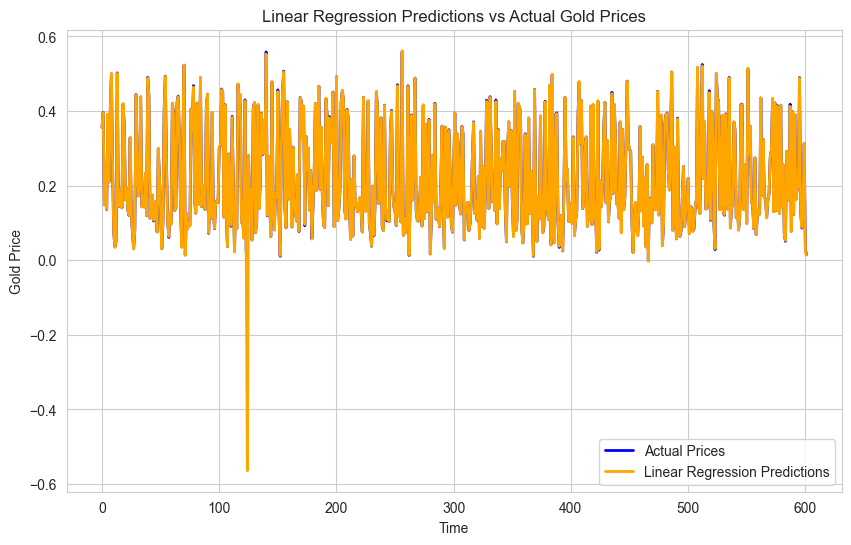

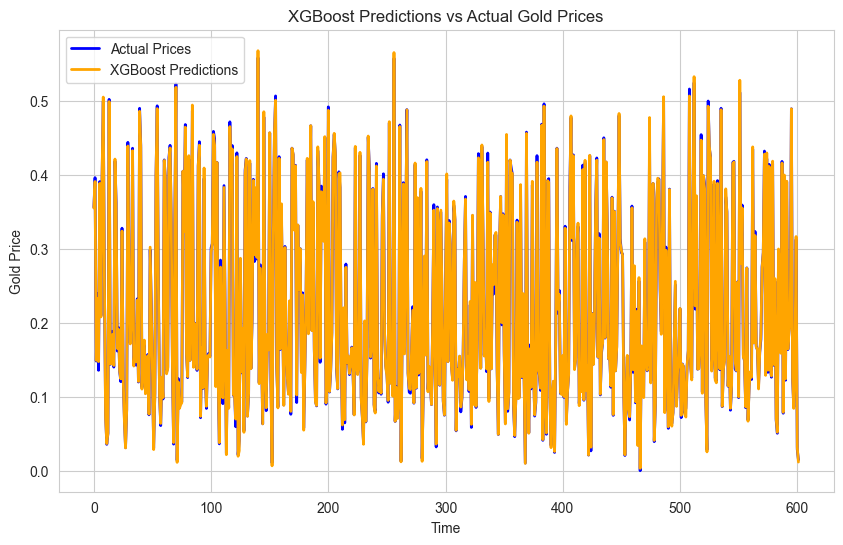

In [21]:
for model_name, (model, rmse) in sorted(model_rmses.items(), key=lambda x: x[1][1])[:2]:
    predictions = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Actual Prices", color='blue', linewidth=2)
    plt.plot(predictions, label=f"{model_name} Predictions", color='orange', linewidth=2)
    plt.title(f"{model_name} Predictions vs Actual Gold Prices")
    plt.xlabel("Time")
    plt.ylabel("Gold Price")
    plt.legend()
    plt.grid(True)
    plt.show()


## 9. Log Top Models to MLflow


In [22]:
for model_name, (model, rmse) in sorted(model_rmses.items(), key=lambda x: x[1][1])[:2]:
    with mlflow.start_run(run_name=f"Top Model: {model_name}"):
        mlflow.log_params(model.get_params())
        mlflow.log_metric("RMSE", rmse)
        mlflow.sklearn.log_model(model, artifact_path="models")


2024/12/18 12:12:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Top Model: Linear Regression at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1/runs/6a1eb0eb66b04d2598598c83fad0bc0a
🧪 View experiment at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1


2024/12/18 12:12:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Top Model: XGBoost at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1/runs/5286d66d519c4e2c90f7a525bdb65cb0
🧪 View experiment at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1
